# North Park Walkshed and Bikeshed Analysis
*Code prepared by Benjamin Tarver. Last updated 14 February 2025.*

**Script Objective**: To numerically assess and visualize/tabulate the accessibility of essential needs in North Park (NP), San Diego (SD), via active transportation.

Note: All files not user-generated which are imported into this script can be found under the exact same name at https://geo.sandag.org/portal/apps/experiencebuilder/experience/?id=fad9e9c038c84f799b5378e4cc3ed068&page=Home

### Import (potentially) necessary packages

In [1]:
import geopandas as gpd # Geospatial data organization package
import pandas as pd # Generic data organization package
import osmnx as ox # Geospatial data extraction (from OpenStreetMap) and analysis package
from shapely import unary_union # Command for merging polygons
from shapely.geometry import Point, Polygon, MultiPolygon, LineString # Geometry objects
import networkx as nx # Graph theory package
import matplotlib.pyplot as plt # Plotting package
import matplotlib.ticker as mticker # For formatting graph axes
import numpy as np # Numerical methods package
import pyproj # For projecting point geometries

## Extract necessary data for analysis

### (MUST RUN FOR OTHER SECTIONS TO EXECUTE) Import SDPD file, extract geometry of NP boundary

EPSG:2230


<Axes: >

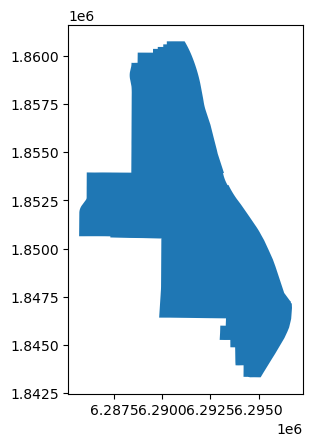

In [7]:
# Import file
gdf_sdpd = gpd.read_file('SDPD_Beats.geojson')
print(gdf_sdpd.crs)
# Extract polygons with boundaries of North Park
northpark_gdf = gdf_sdpd[gdf_sdpd['name'].str.contains("NORTH PARK|BURLINGAME", na=False, case=False)]
northpark_adjacent_gdf = gdf_sdpd[gdf_sdpd['name'].str.contains(
    "BALBOA PARK|HILLCREST|UNIVERSITY HEIGHTS|ADAMS NORTH|NORMAL HEIGHTS|CORRIDOR|CHEROKEE POINT|SOUTH PARK", 
    na=False, case=False)]
# Merge polygons
polygons = list(northpark_gdf['geometry']) + list(northpark_adjacent_gdf['geometry'])
np_bounds = gpd.GeoSeries(unary_union(northpark_gdf['geometry']))
np_and_neighbors_bounds = gpd.GeoSeries(unary_union(polygons))
# Set CRS for polygons, plot
np_bounds = np_bounds.set_crs('EPSG:2230')
np_and_neighbors_bounds = np_and_neighbors_bounds.set_crs('EPSG:2230')
np_bounds.plot()

### Import land use file, extract only NP residence data, save data

In [3]:
# Import file
gdf_landuse = gpd.read_file('Land_Use_2023.geojson')

<Axes: >

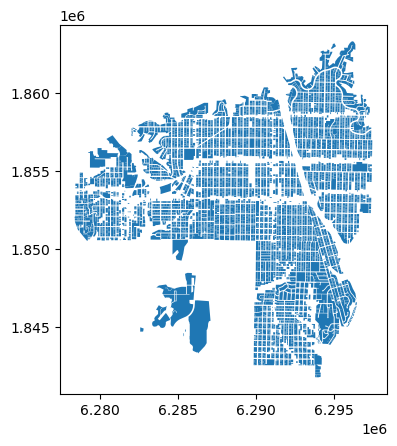

In [4]:
# Extract geometries inside the predetermined NP bounds, plot
# See: https://www.sandag.org/-/media/SANDAG/Documents/PDF/regional-plan/sustainable-growth-and-development/land-use/land-use-codes-2022.pdf
# Define uses of interest based on land use code
single_family_uses = [1000, 1090, 1100, 1110, 1120, 1190]
multi_family_uses = [1200, 1290, 9700]
other_housing_uses = [1280, 1300, 1402, 1403, 1404, 1409]
services_of_interest = [6003, 6103, 6104, 6105, 6109]
medical_uses = [6501, 6502, 6509]
education_uses = [6801, 6802, 6803, 6804, 6805, 6806, 6809]
all_uses = [*single_family_uses,*multi_family_uses,*other_housing_uses,
            *services_of_interest,*medical_uses,*education_uses]
# Find uses within NP matching interests
np_landuse_residential = gdf_landuse[gdf_landuse.within(np_bounds.geometry.iloc[0])]
np_landuse = gdf_landuse[gdf_landuse.within(np_and_neighbors_bounds.geometry.iloc[0])]
np_landuse = np_landuse.loc[np_landuse['lu'].isin(all_uses)]
# Also create more targeted GDFs for specific uses
np_residential_uses = np_landuse_residential.loc[np_landuse_residential['lu'].isin(
    [*single_family_uses,*multi_family_uses,*other_housing_uses])]
np_service_uses = np_landuse.loc[np_landuse['lu'].isin(services_of_interest)]
np_medical_uses = np_landuse.loc[np_landuse['lu'].isin(medical_uses)]
np_education_uses = np_landuse.loc[np_landuse['lu'].isin(education_uses)]
# Plot all uses
np_landuse.plot()

In [5]:
# Export files
np_landuse.to_file('NP_Land_Use_2023.geojson')
np_residential_uses.to_file('NP_Residential_Land_Use_2023.geojson')
np_service_uses.to_file('NP_Services_Land_Use_2023.geojson')
np_medical_uses.to_file('NP_Medical_Land_Use_2023.geojson')
np_education_uses.to_file('NP_Educational_Land_Use_2023.geojson')

<Axes: >

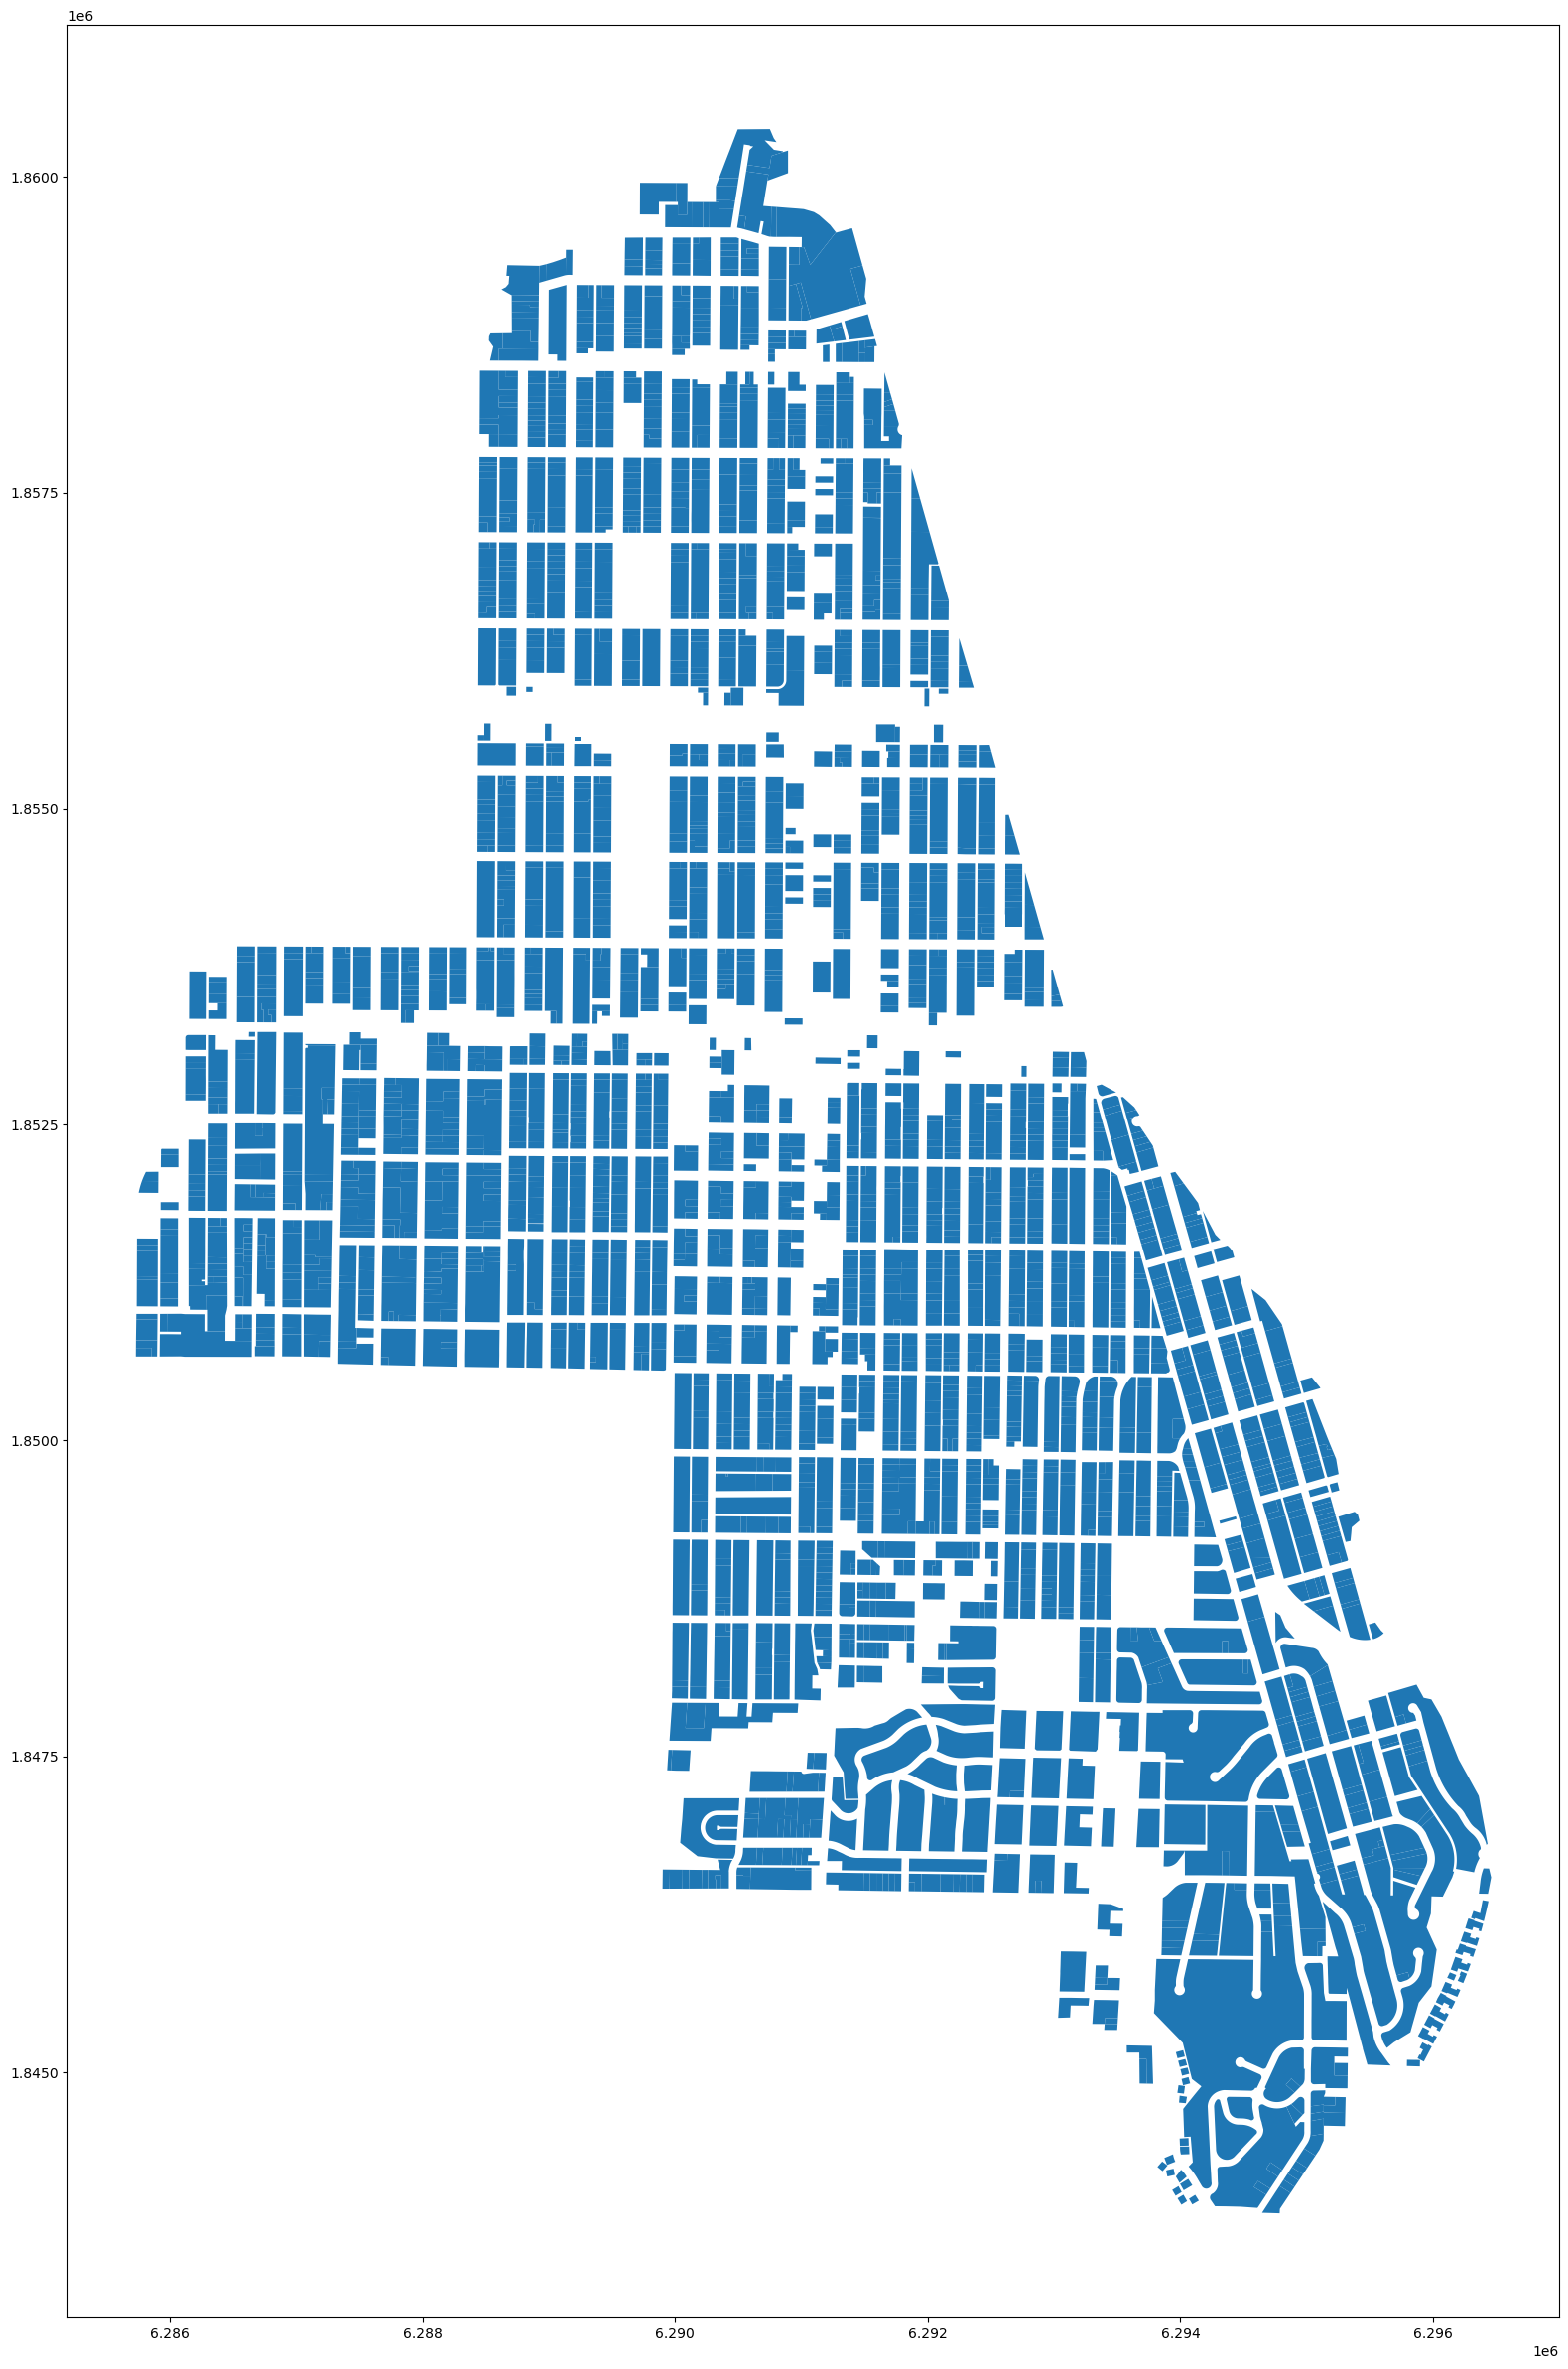

In [6]:
np_residential_uses.plot(figsize=(20,30))

### Import bikeways file, extract only NP paths data, save data

In [74]:
# Import file
gdf_bikeways = gpd.read_file('Bikeways.geojson')

<Axes: >

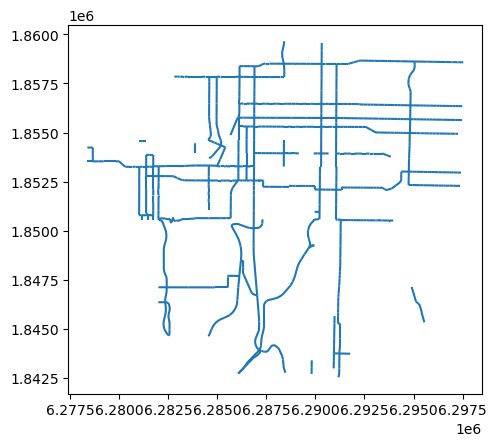

In [75]:
# Extract paths inside the predetermined NP bounds, plot
np_bikeways = gdf_bikeways[gdf_bikeways.within(np_and_neighbors_bounds.geometry.iloc[0])]
np_bikeways.plot()

In [76]:
# Export file
np_bikeways.to_file('NP_Bikeways.geojson')

### Use OSMNx to get pedestrian pathways, save data


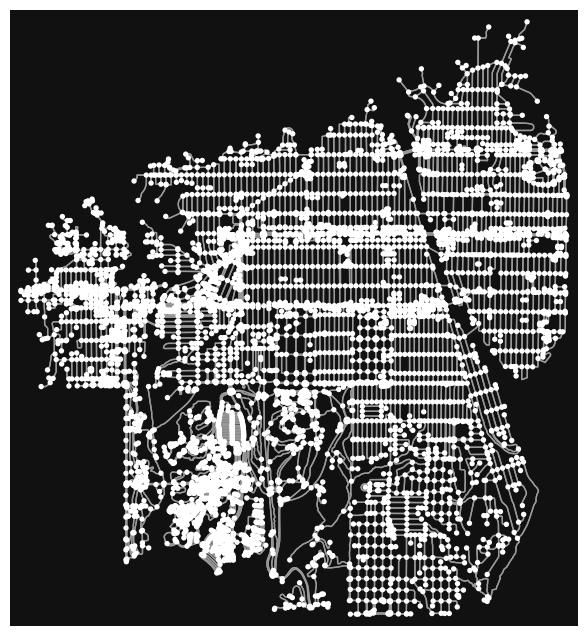

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [7]:
# Create pedestrian pathways graph within NP boundaries
ox_paths = ox.graph.graph_from_polygon(np_and_neighbors_bounds.to_crs('EPSG:4326').geometry.iloc[0], network_type="walk")
ox.plot.plot_graph(ox_paths)

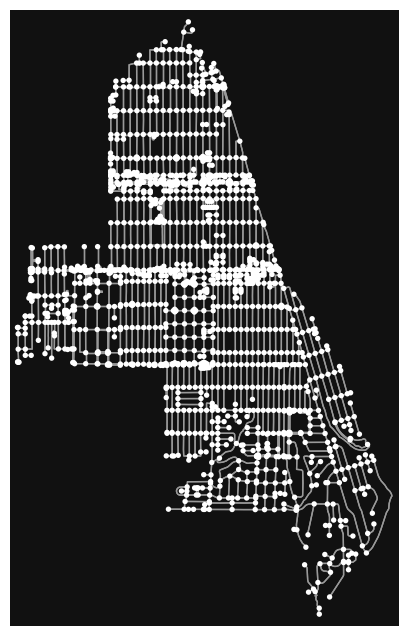

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [8]:
ox_paths_onlynp = ox.graph.graph_from_polygon(np_bounds.to_crs('EPSG:4326').geometry.iloc[0], network_type="walk")
ox.plot.plot_graph(ox_paths_onlynp)

In [9]:
# Export file
ox.io.save_graphml(ox_paths, 'NP_Pedestrian_Graph.graphml')

### Import business sites file, extract NP data on essential needs only (e.g. groceries), save data

In [10]:
# Import file
gdf_businesses = gpd.read_file('Business_Sites.geojson')

<Axes: >

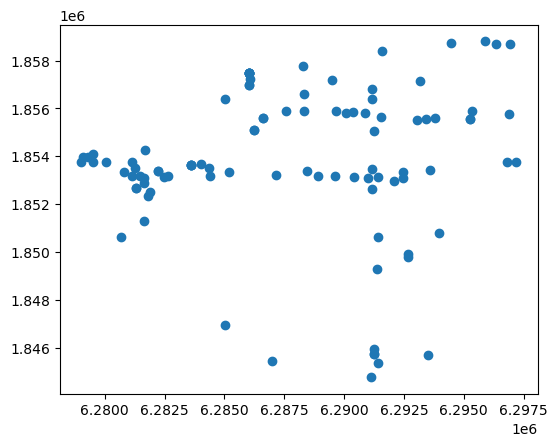

In [11]:
# Extract businesses inside the predetermined NP bounds, plot
# See: https://geo.sandag.org/server/rest/directories/downloads/Business_Sites.pdf
# Name businesses of interest
businesses_of_interest = ['SUPERMARKET','GROCERY STORES','PHARMACY','DRUG STORES','PRE-SCHOOL/CHILDCARE',
                          'BANKS','CREDIT UNION EXEMPT','CREDIT UNION NON EX','CHECK CASHING/MONEY']
# laundry businesses: 'LAUNDRY','LAUNDRY - HAND','COMM LAUND/DRY CLN','LAUNDRY'
# Narrow businesses down to those within bounds and of type of interest
np_businesses = gdf_businesses[gdf_businesses.within(np_and_neighbors_bounds.geometry.iloc[0])]
np_businesses = np_businesses.loc[np_businesses['bustype'].isin(businesses_of_interest)]
np_businesses.plot()

In [293]:
# Export file
np_businesses.to_file('NP_Businesses.geojson')

## Perform residence-specific spatial analyses and aggregate + visualize results

### Calculate walkshed for each residential unit
**Note**: all North Park locations are within a 20 minute bike ride of each other, so "bikesheds" will not be calculated.

In [12]:
# Execute data imports
ox_paths = ox.io.load_graphml(filepath='NP_Pedestrian_Graph.graphml')
np_bikeways = gpd.read_file(filename='NP_Bikeways.geojson')
np_residential_uses = gpd.read_file(filename='NP_Residential_Land_Use_2023.geojson')
np_residential_uses = np_residential_uses.to_crs('EPSG:4326')

In [13]:
# Create a list to store the closest nodes between residence and network
closest_nodes = []

# Iterate through each row in the dataframe
for _, row in np_residential_uses.iterrows():
    row['centroid'] = row.geometry.centroid
    oid = row['objectid']
    latitude = row['centroid'].y
    longitude = row['centroid'].x

    # Use OSMnx to find the nearest node from the OpenStreetMap network
    nearest_node = ox.distance.nearest_nodes(ox_paths, Y=latitude, X=longitude)
    closest_nodes.append((oid, nearest_node))

# Add the closest nodes to the dataframe
np_residential_uses['Closest Node'] = [node[1] for node in closest_nodes]

In [14]:
# Calculate walksheds

# Add speeds + travel times
ox_paths = ox.routing.add_edge_speeds(ox_paths) # pedestrian network -> OSMNx uses logical walking speed
ox_paths = ox.routing.add_edge_travel_times(ox_paths) 
ped_trip_time = 15  # in minutes

# Make the isochrone polygons for the residential land use nodes
walk_isochrone_polys = []
ped_oids = []  # to store the object ids of each building
for _, row in np_residential_uses.iterrows():
    loc_node = row['Closest Node']
    oid = row['objectid']  # Get the land use from the row
    subgraph = nx.ego_graph(ox_paths, loc_node, radius=ped_trip_time, distance="time") # get subgraph geometry within walkshed
    node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)] # get nodes of subgraph within walkshed
    bounding_poly = gpd.GeoSeries(node_points).union_all() # Evaluate union points
    walk_isochrone_polys.append(bounding_poly)
    ped_oids.append(oid)

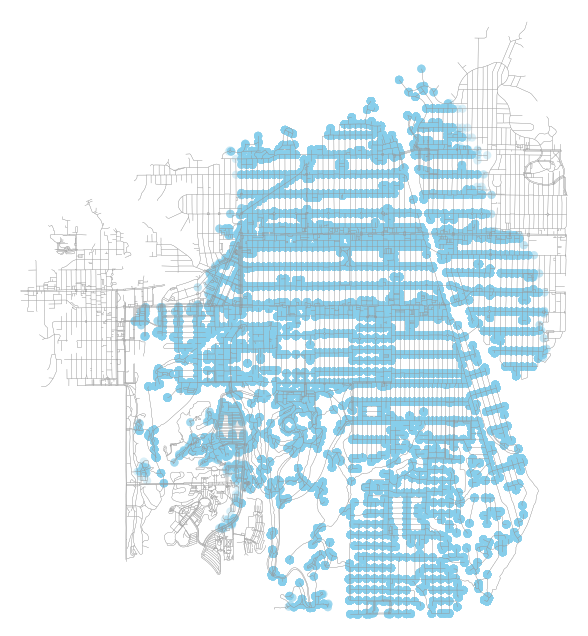

In [15]:
# Graph resulting walksheds and bikesheds
# Create a GeoSeries with separate polygons for each sensor node
walkshed_gdf = gpd.GeoDataFrame({'objectid': ped_oids, 'geometry': walk_isochrone_polys}, crs="EPSG:4326")

# Plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    ox_paths,show=False, close=False, edge_linewidth=0.2,node_size=0,bgcolor='none'
)
walkshed_gdf.plot(ax=ax, color='skyblue', ec="none", alpha=0.3, zorder=-1)
plt.show()

In [16]:
# Import other datasets and convert to EPSG 4326 if necessary
np_service_uses = gpd.read_file('NP_Services_Land_Use_2023.geojson')
np_medical_uses = gpd.read_file('NP_Medical_Land_Use_2023.geojson')
np_education_uses = gpd.read_file('NP_Educational_Land_Use_2023.geojson')
np_businesses = gpd.read_file('NP_Businesses.geojson')
np_service_uses = np_service_uses.to_crs('EPSG:4326')
np_medical_uses = np_medical_uses.to_crs('EPSG:4326')
np_education_uses = np_education_uses.to_crs('EPSG:4326')
np_businesses = np_businesses.to_crs('EPSG:4326')

In [17]:
# Calculate closest nodes for other buildings in land use dataset as well
# Create a list to store the closest nodes between building and network
closest_nodes_edu = []
closest_nodes_serv = []
closest_nodes_med = []
closest_nodes_loop = [closest_nodes_edu, closest_nodes_serv, closest_nodes_med]
landuses = [np_education_uses, np_service_uses, np_medical_uses]

# Iterate through each row in the dataframe
for i in range(len(landuses)):
    for _, row in landuses[i].iterrows():
        row['centroid'] = row.geometry.centroid
        oid = row['objectid']
        latitude = row['centroid'].y
        longitude = row['centroid'].x

        # Use OSMnx to find the nearest node from the OpenStreetMap network
        nearest_node = ox.distance.nearest_nodes(ox_paths, Y=latitude, X=longitude)
        closest_nodes_loop[i].append((oid, nearest_node))

    # Add the closest nodes to the dataframe
    landuses[i]['Closest Node'] = [node[1] for node in closest_nodes_loop[i]]


# Calculate closest nodes for businesses in land use dataset (handled differently than land use datasets based on data structure)
closest_nodes_biz = []

# Iterate through each row in the dataframe
for _, row in np_businesses.iterrows():
    oid = row['objectid']
    latitude = row['geometry'].y
    longitude = row['geometry'].x

    # Use OSMnx to find the nearest node from the OpenStreetMap network
    nearest_node = ox.distance.nearest_nodes(ox_paths, Y=latitude, X=longitude)
    closest_nodes_biz.append((oid, nearest_node))

# Add the closest nodes to the dataframe
np_businesses['Closest Node'] = [node[1] for node in closest_nodes_biz]

In [ ]:
# # Find the intersection of business nodes and graph nodes
# node_find = set(np_businesses['Closest Node']).intersection(list(ox_paths.nodes))

# # Create a figure and axis to plot both graphs on the same plot
# fig, ax = plt.subplots(figsize=(10, 10))

# # Plot the full graph using OSMNx
# ox.plot_graph(ox_paths, ax=ax, show=False, close=False, edge_linewidth=0.2, node_size=0, bgcolor='none')

# # Overlay the subgraph using NetworkX
# subgraph = ox_paths.subgraph(node_find)
# pos = {node: (ox_paths.nodes[node]['x'], ox_paths.nodes[node]['y']) for node in subgraph.nodes}
# nx.draw(subgraph, pos=pos, ax=ax, with_labels=True, node_color="red", edge_color="blue")

# # Show the combined plot
# plt.show()

### Score accessibility of different walksheds

/var/folders/v8/9cfy1gdx1sld3kvlqhb266v80000gn/T/ipykernel_38190/3995527020.py:28: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G_NP_big = ox.graph_from_bbox(32.775,32.715,-117.105,-117.155,retain_all=True)


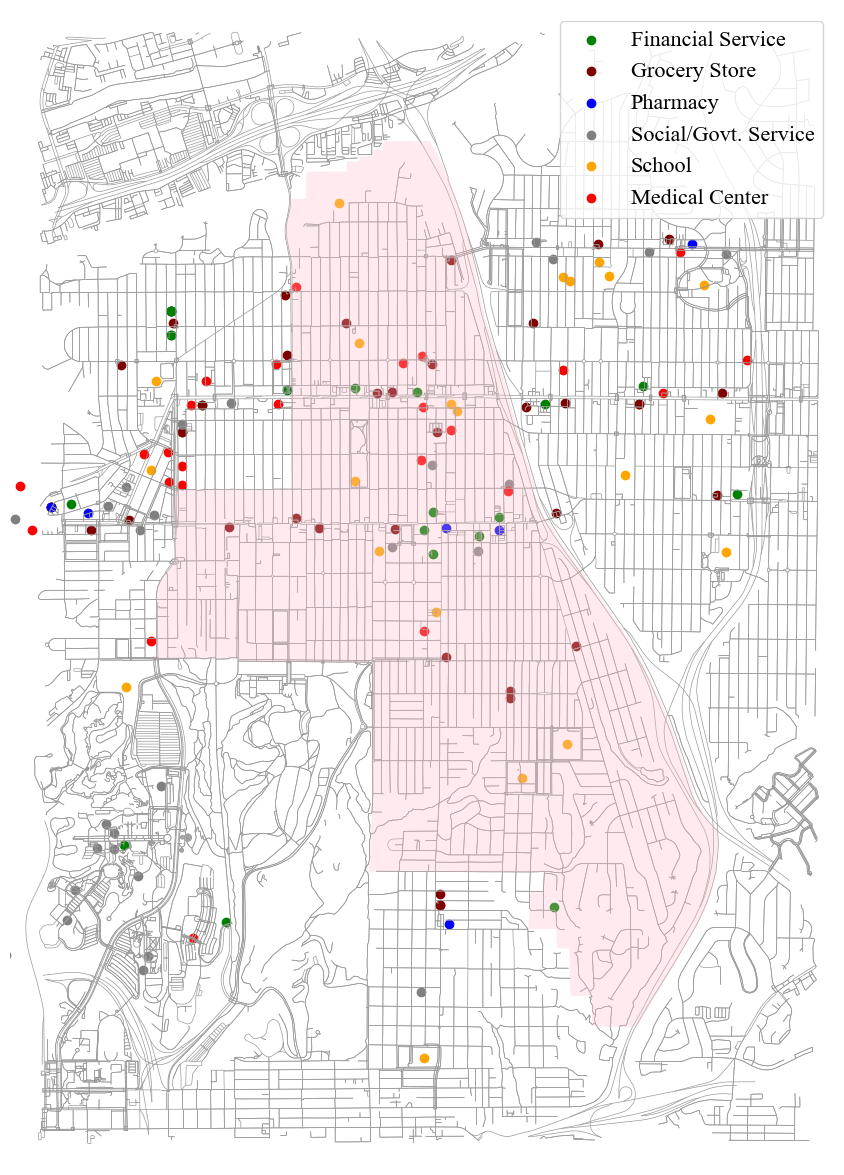

In [32]:
# Define different businesses of interest
np_finance = np_businesses.loc[np_businesses['bustype'].isin(
    ['BANKS','CREDIT UNION EXEMPT','CREDIT UNION NON EX','CHECK CASHING/MONEY'])]
np_grocery = np_businesses.loc[np_businesses['bustype'].isin(['SUPERMARKET','GROCERY STORES'])]
np_pharma = np_businesses.loc[np_businesses['bustype'].isin(['PHARMACY','DRUG STORES'])]
np_childcare = np_businesses.loc[np_businesses['bustype'].isin(['PRE-SCHOOL/CHILDCARE'])]

# Plot locations of different access needs of interest

# Calculate centroids of polygon-represented land uses
np_service_uses_temp = np_service_uses.to_crs('EPSG:2230').copy(deep=True)
np_education_uses_temp = np_education_uses.to_crs('EPSG:2230').copy(deep=True)
np_medical_uses_temp = np_medical_uses.to_crs('EPSG:2230').copy(deep=True)
np_service_uses_temp['geometry'] = np_service_uses_temp['geometry'].centroid
np_education_uses_temp['geometry'] = np_education_uses_temp['geometry'].centroid
np_medical_uses_temp['geometry'] = np_medical_uses_temp['geometry'].centroid

# Plot land uses along with NP boundary, street network
_, ax = plt.subplots(figsize=(20, 15))
finplot = np_finance.plot(ax=ax, color="green", label='Financial Service')
grplot = np_grocery.plot(ax=ax, color="maroon", label='Grocery Store')
rxplot = np_pharma.plot(ax=ax, color="blue", label='Pharmacy')
cplot = np_childcare.plot(ax=ax, color="orange", label='Childcare Center')
sgplot = np_service_uses_temp.to_crs('EPSG:4326').plot(ax=ax, color="gray", label='Social/Govt. Service')
edplot = np_education_uses_temp.to_crs('EPSG:4326').plot(ax=ax, color="orange", label='School')
medplot = np_medical_uses_temp.to_crs('EPSG:4326').plot(ax=ax, color="red", label='Medical Center')
# Get network graph around North Park area for visualization purposes
G_NP_big = ox.graph_from_bbox(32.775,32.715,-117.105,-117.155,retain_all=True)
ox.plot_graph(G_NP_big, ax=ax, node_size=0, edge_linewidth=0.5, bgcolor="none", show=False, close=False)
np_bounds.to_crs('EPSG:4326').plot(ax=ax, alpha=0.3, color='pink')
ax.legend(prop={'family': 'Times New Roman', 'size': 16})
plt.show()

In [ ]:
# Calculate if residence has access to X given need via walk (aggregate in the end - tabulated data)
np_finance = np_finance.reset_index(drop=True)
np_grocery = np_grocery.reset_index(drop=True)
np_pharma = np_pharma.reset_index(drop=True)
np_childcare = np_childcare.reset_index(drop=True)
needs_loop_arr = [np_medical_uses, np_service_uses, np_education_uses,
                          np_grocery, np_pharma, np_finance, np_childcare]
subscores_strings = ['Medical Services Access Score', 'Social/Government Services Access Score',
                     'Education Access Score', 'Grocery Access Score', 'Pharmacy Access Score',
                     'Financial Institution Access Score', 'Childcare Access Score']

# initialize access scores (total access score is scalar, others are binary)
walkshed_gdf['Total Access Score'] = 0
walkshed_gdf[subscores_strings] = 0

# loop thru all walksheds and residences, find overlap
for h, row in walkshed_gdf.iterrows():  # 'row' is a copy, modifying it has no effect
    for i in range(len(needs_loop_arr)):
        for j in range(len(needs_loop_arr[i])):
            node = needs_loop_arr[i].iloc[j]['Closest Node']  # Use .iloc for safety
            node_as_pt = Point((ox_paths.nodes[node]["x"], ox_paths.nodes[node]["y"]))

            if node_as_pt.intersects(row['geometry']):
                walkshed_gdf.loc[h, subscores_strings[i]] += 1
                walkshed_gdf.loc[h, 'Total Access Score'] += 1

In [20]:
# Export walkshed GDF
walkshed_gdf.to_file('NP_Walksheds.geojson')

### Generate plots of walkshed access scores (discrete gradient for total, binary coloring for others)


In [21]:
# Perform merge of walkshed scores and NP residences
np_residential_uses_merged = pd.merge(np_residential_uses, walkshed_gdf.drop(['geometry'],axis=1), how='left', on='objectid')

In [22]:
# Get (slightly narrower) network graph around North Park area for visualization purposes
G_NP = ox.graph_from_bbox(32.77,32.72,-117.11,-117.15,retain_all=True)

/var/folders/v8/9cfy1gdx1sld3kvlqhb266v80000gn/T/ipykernel_38190/2885763654.py:2: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G_NP = ox.graph_from_bbox(32.77,32.72,-117.11,-117.15,retain_all=True)


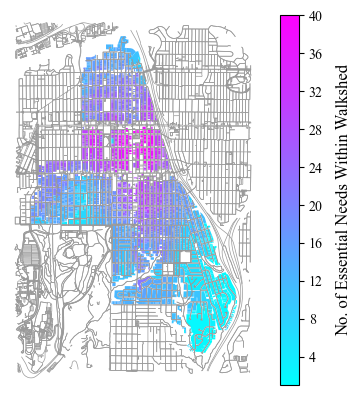

In [23]:
# Plot heatmap for point totals
ax = np_residential_uses_merged.to_crs('EPSG:4326').plot(column = 'Total Access Score', cmap = 'cool', legend=True)
ox.plot_graph(G_NP, ax=ax, node_size=0, edge_linewidth=0.5, bgcolor="none", show=False, close=False)
colorbar = ax.get_figure().get_axes()[1]
colorbar.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
colorbar.set_ylabel("No. of Essential Needs Within Walkshed", 
                    labelpad=10, fontsize=12, fontfamily='Times New Roman')
colorbar.yaxis.set_tick_params(labelsize=10, labelfontfamily='Times New Roman') 
plt.show()

In [24]:
# Export merged residential uses GDF
np_residential_uses_merged.to_file('NP_Scored_Uses.geojson')

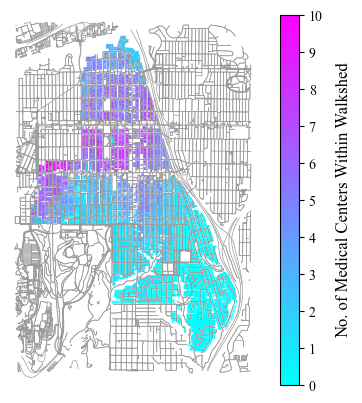

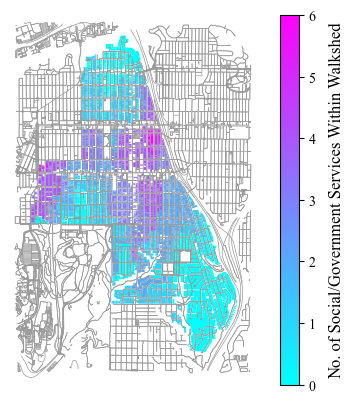

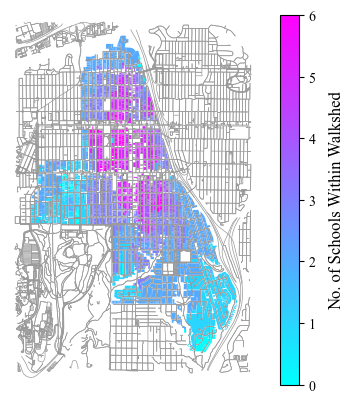

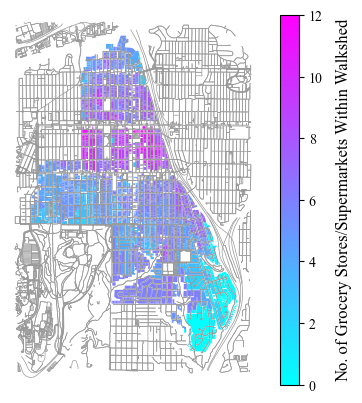

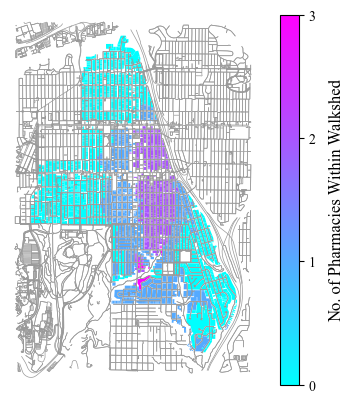

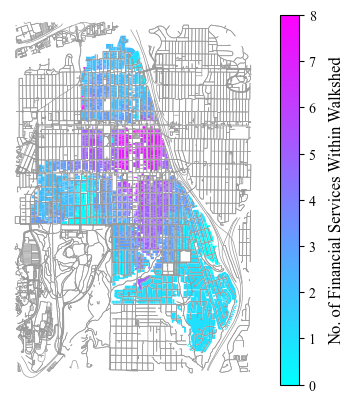

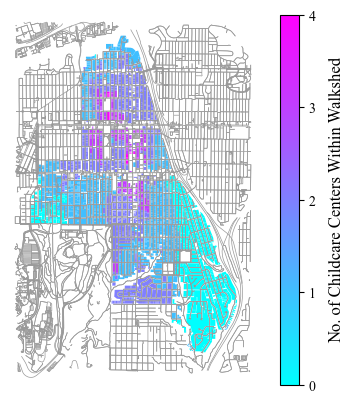

In [34]:
# Create more plots for specific access needs

# Medical Needs
ax_med = np_residential_uses_merged.to_crs('EPSG:4326').plot(
    column = 'Medical Services Access Score', cmap = 'cool', legend=True)
ox.plot_graph(G_NP, ax=ax_med, node_size=0, edge_linewidth=0.5, bgcolor="none", show=False, close=False)
colorbar = ax_med.get_figure().get_axes()[1]
colorbar.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
colorbar.set_ylabel("No. of Medical Centers Within Walkshed", 
                    labelpad=10, fontsize=12, fontfamily='Times New Roman')
colorbar.yaxis.set_tick_params(labelsize=10, labelfontfamily='Times New Roman') 

# Social/Government Services
ax_sg = np_residential_uses_merged.to_crs('EPSG:4326').plot(
    column = 'Social/Government Services Access Score', cmap = 'cool', legend=True)
ox.plot_graph(G_NP, ax=ax_sg, node_size=0, edge_linewidth=0.5, bgcolor="none", show=False, close=False)
colorbar = ax_sg.get_figure().get_axes()[1]
colorbar.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
colorbar.set_ylabel("No. of Social/Government Services Within Walkshed", 
                    labelpad=10, fontsize=12, fontfamily='Times New Roman')
colorbar.yaxis.set_tick_params(labelsize=10, labelfontfamily='Times New Roman') 

# Education Services
ax_ed = np_residential_uses_merged.to_crs('EPSG:4326').plot(
    column = 'Education Access Score', cmap = 'cool', legend=True)
ox.plot_graph(G_NP, ax=ax_ed, node_size=0, edge_linewidth=0.5, bgcolor="none", show=False, close=False)
colorbar = ax_ed.get_figure().get_axes()[1]
colorbar.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
colorbar.set_ylabel("No. of Schools Within Walkshed", 
                    labelpad=10, fontsize=12, fontfamily='Times New Roman')
colorbar.yaxis.set_tick_params(labelsize=10, labelfontfamily='Times New Roman') 

# Grocery Access
ax_gr = np_residential_uses_merged.to_crs('EPSG:4326').plot(
    column = 'Grocery Access Score', cmap = 'cool', legend=True)
ox.plot_graph(G_NP, ax=ax_gr, node_size=0, edge_linewidth=0.5, bgcolor="none", show=False, close=False)
colorbar = ax_gr.get_figure().get_axes()[1]
colorbar.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
colorbar.set_ylabel("No. of Grocery Stores/Supermarkets Within Walkshed", 
                    labelpad=10, fontsize=12, fontfamily='Times New Roman')
colorbar.yaxis.set_tick_params(labelsize=10, labelfontfamily='Times New Roman') 

# Pharmacy Access
ax_rx = np_residential_uses_merged.to_crs('EPSG:4326').plot(
    column = 'Pharmacy Access Score', cmap = 'cool', legend=True)
ox.plot_graph(G_NP, ax=ax_rx, node_size=0, edge_linewidth=0.5, bgcolor="none", show=False, close=False)
colorbar = ax_rx.get_figure().get_axes()[1]
colorbar.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
colorbar.set_ylabel("No. of Pharmacies Within Walkshed", 
                    labelpad=10, fontsize=12, fontfamily='Times New Roman')
colorbar.yaxis.set_tick_params(labelsize=10, labelfontfamily='Times New Roman') 


# Financial Access
ax_fin = np_residential_uses_merged.to_crs('EPSG:4326').plot(
    column = 'Financial Institution Access Score', cmap = 'cool', legend=True)
ox.plot_graph(G_NP, ax=ax_fin, node_size=0, edge_linewidth=0.5, bgcolor="none", show=False, close=False)
colorbar = ax_fin.get_figure().get_axes()[1]
colorbar.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
colorbar.set_ylabel("No. of Financial Services Within Walkshed", 
                    labelpad=10, fontsize=12, fontfamily='Times New Roman')
colorbar.yaxis.set_tick_params(labelsize=10, labelfontfamily='Times New Roman') 

# Childcare Access
ax_ch = np_residential_uses_merged.to_crs('EPSG:4326').plot(
    column = 'Childcare Access Score', cmap = 'cool', legend=True)
ox.plot_graph(G_NP, ax=ax_ch, node_size=0, edge_linewidth=0.5, bgcolor="none", show=False, close=False)
colorbar = ax_ch.get_figure().get_axes()[1]
colorbar.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
colorbar.set_ylabel("No. of Childcare Centers Within Walkshed", 
                    labelpad=10, fontsize=12, fontfamily='Times New Roman')
colorbar.yaxis.set_tick_params(labelsize=10, labelfontfamily='Times New Roman') 

plt.show()

In [26]:
# Calculate percentage of bikeshed that overlaps with formally recognized paths (heat map opportunity)
# Reimport file, if necessary
np_bikeways = gpd.read_file('NP_Bikeways.geojson')

(<Figure size 640x480 with 1 Axes>, <Axes: >)

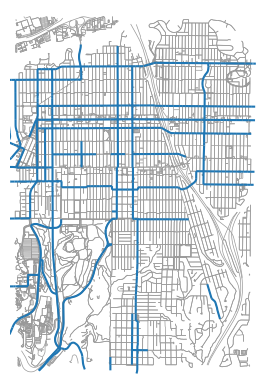

In [27]:
ax = np_bikeways.to_crs('EPSG:4326').plot()
ox.plot_graph(G_NP, ax=ax, node_size=0, edge_linewidth=0.5, bgcolor="none", show=False, close=False)

In [28]:
# Calculate overlap betwee nodes of walkshed and bike paths
np_bikeways = np_bikeways.to_crs('EPSG:2230')
ped_trip_time = 15  # in minutes

# Precompute bikeway union and create a spatial index, define transformer
np_bikeways_union = list(np_bikeways.union_all().geoms)  # Precompute union to avoid redundant calculations
np_bikeways_union = gpd.GeoSeries(np_bikeways_union, crs=('EPSG:2230'))
transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:2230", always_xy=True)

overlap_percents = []
overlap_oids = []  # to store the object ids of each building
for _, row in np_residential_uses.iterrows():
    loc_node = row['Closest Node']
    oid = row['objectid']  
    subgraph = nx.ego_graph(ox_paths, loc_node, radius=ped_trip_time, distance="time")  
    
    # Convert edges to a GeoDataFrame
    edges = []
    for u, v, data in subgraph.edges(data=True):
        point_u = transformer.transform(subgraph.nodes[u]["x"], subgraph.nodes[u]["y"])
        point_v = transformer.transform(subgraph.nodes[v]["x"], subgraph.nodes[v]["y"])
        edges.append((u, v, LineString([point_u, point_v])))

    gdf_edges = gpd.GeoDataFrame(edges, columns=["u", "v", "geometry"], geometry="geometry", crs="EPSG:2230")
    # print(gdf_edges.head())

    # Skip if no edges exist
    if gdf_edges.empty:
        print(f"No edges found for objectid {oid}")
        continue  

    # Compute total edge length and intersections
    total_edge_length = gdf_edges.length.sum()
    gdf_edges["overlap"] = gdf_edges.geometry.buffer(100).intersects(np_bikeways_union, align=True) # give buffer to allow for slight imprecise alignment
    overlapping_length = gdf_edges.loc[gdf_edges["overlap"], "geometry"].length.sum()

    # Compute overlap percentage
    overlap_percentage = (overlapping_length / total_edge_length) * 100 if total_edge_length > 0 else 0
    overlap_percents.append(overlap_percentage)
    overlap_oids.append(oid)
overlap_df = pd.DataFrame(data={'objectid': overlap_oids, 'Overlap Percentage': overlap_percents})

In [29]:
# Import files if necessary
np_residential_uses_merged = gpd.read_file('NP_Scored_Uses.geojson')

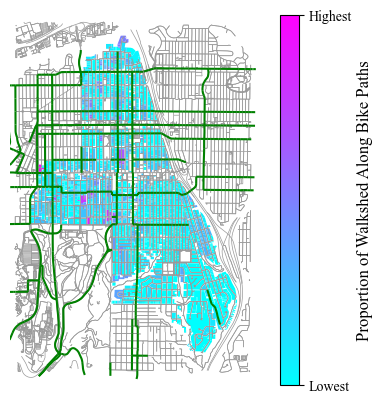

In [30]:
# Plot residences with best bike access
np_residential_uses_merged_bike = pd.merge(np_residential_uses_merged, overlap_df, how='left', on='objectid')
ax = np_residential_uses_merged_bike.to_crs('EPSG:4326').plot(
    column = 'Overlap Percentage', cmap = 'cool', legend=True)
np_bikeways.to_crs('EPSG:4326').plot(ax=ax, color='green')
ox.plot_graph(G_NP, ax=ax, node_size=0, edge_linewidth=0.5, bgcolor="none", show=False, close=False)
colorbar = ax.get_figure().get_axes()[1]
colorbar.set_ylabel("Proportion of Walkshed Along Bike Paths", fontsize=12, fontfamily='Times New Roman')
colorbar.yaxis.set_ticks([0, max(overlap_df['Overlap Percentage'])])
colorbar.yaxis.set_ticklabels(['Lowest', 'Highest'])
colorbar.yaxis.set_tick_params(labelsize=10, labelfontfamily='Times New Roman') 
plt.show()

In [31]:
# Export merged residential uses GDF
np_residential_uses_merged_bike.to_file('NP_Scored_Uses_Bike.geojson')

### Discretize Accessibility by Housing Type

In [ ]:
# Import file(s) if necessary
np_residential_uses_merged = gpd.read_file('NP_Scored_Uses.geojson')
np_residential_uses_merged_bike = gpd.read_file('NP_Scored_Uses_Bike.geojson')

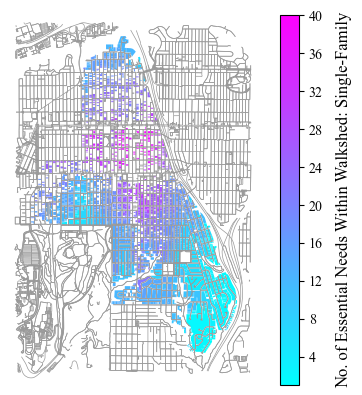

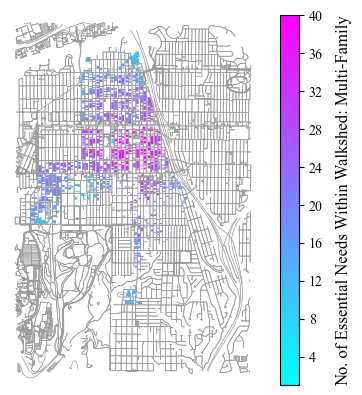

In [33]:
# Separate single-family from multi-family housing units in heatmaps
single_family_uses = [1000, 1090, 1100, 1110, 1120, 1190]
multi_family_uses = [1200, 1290, 9700]
np_single_residential = np_residential_uses_merged.loc[np_residential_uses_merged['lu'].isin([*single_family_uses])]
np_multi_residential = np_residential_uses_merged.loc[np_residential_uses_merged['lu'].isin([*multi_family_uses])]

# Plot heatmap for point totals
ax_sf = np_single_residential.to_crs('EPSG:4326').plot(column = 'Total Access Score', cmap = 'cool', legend=True)
colorbar = ax_sf.get_figure().get_axes()[1]
colorbar.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
colorbar.set_ylabel("No. of Essential Needs Within Walkshed: Single-Family", 
                    labelpad=10, fontsize=12, fontfamily='Times New Roman')
colorbar.yaxis.set_tick_params(labelsize=10, labelfontfamily='Times New Roman') 
ox.plot_graph(G_NP, ax=ax_sf, node_size=0, edge_linewidth=0.5, bgcolor="none", show=False, close=False)

ax_mf = np_multi_residential.to_crs('EPSG:4326').plot(column = 'Total Access Score', cmap = 'cool', legend=True)
colorbar = ax_mf.get_figure().get_axes()[1]
colorbar.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
colorbar.set_ylabel("No. of Essential Needs Within Walkshed: Multi-Family", 
                    labelpad=10, fontsize=12, fontfamily='Times New Roman')
colorbar.yaxis.set_tick_params(labelsize=10, labelfontfamily='Times New Roman') 
ox.plot_graph(G_NP, ax=ax_mf, node_size=0, edge_linewidth=0.5, bgcolor="none", show=False, close=False)

plt.show()

## Compare Accessibility in North Park to City of San Diego

In [4]:
# Redo actions completed in above script if necessary
# Import files
gdf_sdpd = gpd.read_file('SDPD_Beats.geojson')
gdf_landuse = gpd.read_file('Land_Use_2023.geojson')
gdf_businesses = gpd.read_file('Business_Sites.geojson')
# Extract geometries inside the predetermined NP bounds, plot
# See: https://www.sandag.org/-/media/SANDAG/Documents/PDF/regional-plan/sustainable-growth-and-development/land-use/land-use-codes-2022.pdf
# Define uses of interest based on land use code
single_family_uses = [1000, 1090, 1100, 1110, 1120, 1190]
multi_family_uses = [1200, 1290, 9700]
other_housing_uses = [1280, 1300, 1402, 1403, 1404, 1409]
services_of_interest = [6003, 6103, 6104, 6105, 6109]
medical_uses = [6501, 6502, 6509]
education_uses = [6801, 6802, 6803, 6804, 6805, 6806, 6809]
all_uses = [*single_family_uses,*multi_family_uses,*other_housing_uses,
            *services_of_interest,*medical_uses,*education_uses]
# Name businesses of interest
businesses_of_interest = ['SUPERMARKET','GROCERY STORES','PHARMACY','DRUG STORES','PRE-SCHOOL/CHILDCARE',
                          'BANKS','CREDIT UNION EXEMPT','CREDIT UNION NON EX','CHECK CASHING/MONEY']

In [5]:
# Redefine North Park's and its neighbors' boundaries
# Import municipal boundaries file
gdf_municipal = gpd.read_file('Municipal_Boundaries.geojson')
# Extract polygons with boundaries of North Park, closeby neighborhoods, and San Diego
northpark_and_walkable_neighbors_gdf = gdf_sdpd[gdf_sdpd['name'].str.contains(
    "NORTH PARK|BURLINGAME|HILLCREST|UNIVERSITY HEIGHTS|ADAMS NORTH|NORMAL HEIGHTS|SOUTH PARK", na=False, case=False)]
northpark_neighbor_neighbors_gdf = gdf_sdpd[gdf_sdpd['name'].str.contains(
    "KENSINGTON|CORRIDOR|TERALTA WEST|MISSION VALLEY EAST|MISSION VALLEY WEST|MISSION HILLS|MIDTOWN|PARK WEST|BALBOA PARK|GOLDEN HILL|STOCKTON",
    na=False, case=False)]
sandiego_gdf = gdf_municipal[gdf_municipal['name'].str.contains('SAN DIEGO', na=False, case=False)]
# Merge polygons
polygons = list(northpark_and_walkable_neighbors_gdf['geometry']) + list(northpark_neighbor_neighbors_gdf['geometry'])
np_neighbors_bounds = gpd.GeoSeries(unary_union(northpark_and_walkable_neighbors_gdf['geometry']))
np_neighbors_neighbors_bounds = gpd.GeoSeries(unary_union(polygons))
sd_bounds = gpd.GeoSeries(unary_union(sandiego_gdf['geometry']))
# Set CRS for polygons
np_neighbors_bounds = np_neighbors_bounds.set_crs('EPSG:2230')
np_neighbors_neighbors_bounds = np_neighbors_neighbors_bounds.set_crs('EPSG:2230')
sd_bounds = sd_bounds.set_crs('EPSG:2230')

In [81]:
# Delete small noncontiguous zones of San Diego from analysis
def get_largest_polygon(multi_poly):
    if isinstance(multi_poly, Polygon):  
        return multi_poly  # If it's already a single polygon, return it
    
    # Convert MultiPolygon to a sorted list of Polygons by area (largest first)
    polygons = sorted(multi_poly.geoms, key=lambda p: p.area, reverse=True)
    
    # Return the largest polygon
    return polygons[0]

sd_bounds = get_largest_polygon(sd_bounds[0])
sd_bounds = gpd.GeoSeries(sd_bounds, crs='EPSG:2230')

<Axes: >

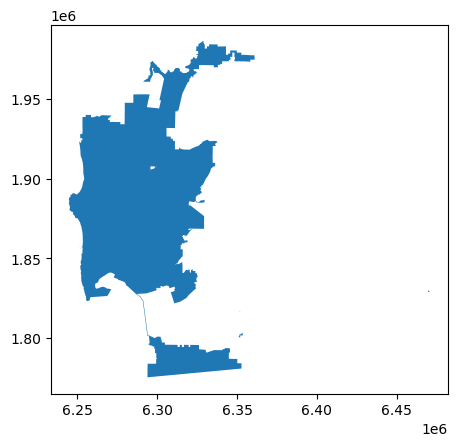

In [181]:
sd_bounds.plot()

In [144]:
# Find uses within NP + walkable neighbors matching interests
np_n_landuse_residential = gdf_landuse[gdf_landuse.within(np_neighbors_bounds.geometry.iloc[0])]
np_n_landuse = gdf_landuse[gdf_landuse.within(np_neighbors_neighbors_bounds.geometry.iloc[0])]
np_n_landuse = np_n_landuse.loc[np_n_landuse['lu'].isin(all_uses)]
sd_landuse = gdf_landuse[gdf_landuse.within(sd_bounds.geometry.iloc[0])]
sd_landuse = sd_landuse.loc[sd_landuse['lu'].isin(all_uses)]

# Also create more targeted GDFs for specific uses
np_n_residential_uses = np_n_landuse_residential.loc[np_n_landuse_residential['lu'].isin(
    [*single_family_uses,*multi_family_uses,*other_housing_uses])]
np_n_service_uses = np_n_landuse.loc[np_n_landuse['lu'].isin(services_of_interest)]
np_n_medical_uses = np_n_landuse.loc[np_n_landuse['lu'].isin(medical_uses)]
np_n_education_uses = np_n_landuse.loc[np_n_landuse['lu'].isin(education_uses)]
sd_residential_uses = sd_landuse.loc[sd_landuse['lu'].isin(
    [*single_family_uses,*multi_family_uses,*other_housing_uses])]
sd_service_uses = sd_landuse.loc[sd_landuse['lu'].isin(services_of_interest)]
sd_medical_uses = sd_landuse.loc[sd_landuse['lu'].isin(medical_uses)]
sd_education_uses = sd_landuse.loc[sd_landuse['lu'].isin(education_uses)]

# # Plot all uses for NP + neighbors
# np_n_landuse.plot()

In [145]:
# Narrow businesses down to those within bounds and of type of interest
np_n_businesses = gdf_businesses[gdf_businesses.within(np_neighbors_neighbors_bounds.geometry.iloc[0])]
np_n_businesses = np_n_businesses.loc[np_n_businesses['bustype'].isin(businesses_of_interest)]
sd_businesses = gdf_businesses[gdf_businesses.within(sd_bounds.geometry.iloc[0])]
sd_businesses = sd_businesses.loc[sd_businesses['bustype'].isin(businesses_of_interest)]
# # Plot businesses
# np_n_businesses.plot()

In [85]:
# Create pedestrian pathways graph within NP + neighbors, SD boundaries
ox_npn_paths = ox.graph.graph_from_polygon(np_neighbors_neighbors_bounds.to_crs('EPSG:4326').geometry.iloc[0], network_type="walk")
ox_sd_paths = ox.graph.graph_from_polygon(sd_bounds.to_crs('EPSG:4326').geometry.iloc[0], network_type="walk")

In [149]:
# Convert residential use GDFs to correct CRS
np_n_residential_uses = np_n_residential_uses.to_crs(epsg=4326)
sd_residential_uses = sd_residential_uses.to_crs(epsg=4326)

In [150]:
# Create a list to store the closest nodes between residence and network
closest_nodes_npn = []

# Iterate through each row in the dataframe
for _, row in np_n_residential_uses.iterrows():
    row['centroid'] = row.geometry.centroid
    oid = row['objectid']
    latitude = row['centroid'].y
    longitude = row['centroid'].x

    # Use OSMnx to find the nearest node from the OpenStreetMap network
    nearest_node = ox.distance.nearest_nodes(ox_npn_paths, Y=latitude, X=longitude)
    closest_nodes_npn.append((oid, nearest_node))

# Add the closest nodes to the dataframe
np_n_residential_uses['Closest Node'] = [node[1] for node in closest_nodes_npn]

In [153]:
# Repeat for SD
closest_nodes_sd = []

# Iterate through each row in the dataframe
for _, row in sd_residential_uses.iterrows():
    row['centroid'] = row.geometry.centroid
    oid = row['objectid']
    latitude = row['centroid'].y
    longitude = row['centroid'].x

    # Use OSMnx to find the nearest node from the OpenStreetMap network
    nearest_node = ox.distance.nearest_nodes(ox_sd_paths, Y=latitude, X=longitude)
    closest_nodes_sd.append((oid, nearest_node))

# Add the closest nodes to the dataframe
sd_residential_uses['Closest Node'] = [node[1] for node in closest_nodes_sd]

In [154]:
# Export residential use datasets
np_n_residential_uses.to_file('NP_and_Neighbors_Residential_Uses.geojson')
sd_residential_uses.to_file('SD_Residential_Uses.geojson')

In [155]:
# Calculate walksheds in NP + neighbors
# Add speeds + travel times
ox_npn_paths = ox.routing.add_edge_speeds(ox_npn_paths) # pedestrian network -> OSMNx uses logical walking speed
ox_npn_paths = ox.routing.add_edge_travel_times(ox_npn_paths) 
ped_trip_time = 15  # in minutes

# Make the isochrone polygons for the residential land use nodes
walk_isochrone_polys_npn = []
ped_oids_npn = []  # to store the object ids of each building
for _, row in np_n_residential_uses.iterrows():
    loc_node = row['Closest Node']
    oid = row['objectid']  # Get the land use from the row
    subgraph = nx.ego_graph(ox_npn_paths, loc_node, radius=ped_trip_time, distance="time") # get subgraph geometry within walkshed
    node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)] # get nodes of subgraph within walkshed
    bounding_poly = gpd.GeoSeries(node_points).union_all() # Evaluate union points
    walk_isochrone_polys_npn.append(bounding_poly)
    ped_oids_npn.append(oid)

# Create a GeoSeries with separate polygons for each sensor node
walkshed_gdf_npn = gpd.GeoDataFrame({'objectid': ped_oids_npn, 'geometry': walk_isochrone_polys_npn}, crs="EPSG:4326")

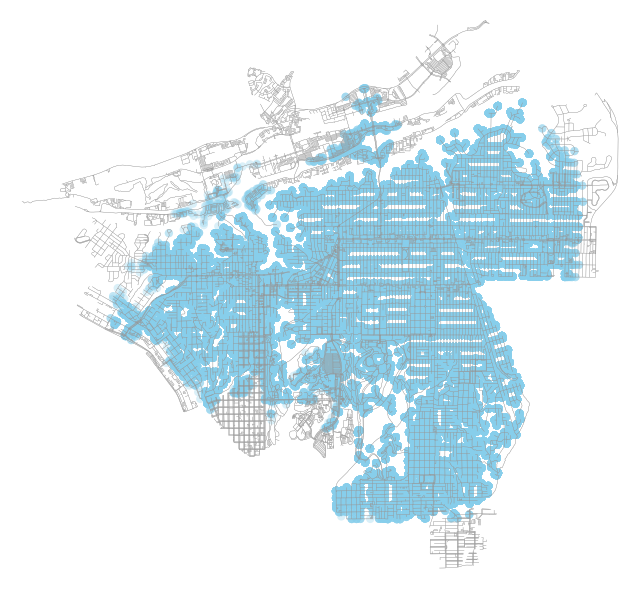

In [156]:
# Plot the network then add isochrones as colored polygon patches
fig, ax = ox.plot_graph(
    ox_npn_paths,show=False, close=False, edge_linewidth=0.2,node_size=0,bgcolor='none'
)
walkshed_gdf_npn.plot(ax=ax, color='skyblue', ec="none", alpha=0.3, zorder=-1)
plt.show()

In [157]:
# Repeat for SD
# Add speeds + travel times
ox_sd_paths = ox.routing.add_edge_speeds(ox_sd_paths) # pedestrian network -> OSMNx uses logical walking speed
ox_sd_paths = ox.routing.add_edge_travel_times(ox_sd_paths) 

# Make the isochrone polygons for the residential land use nodes
walk_isochrone_polys_sd = []
ped_oids_sd = []  # to store the object ids of each building
for _, row in sd_residential_uses.iterrows():
    loc_node = row['Closest Node']
    oid = row['objectid']  # Get the land use from the row
    subgraph = nx.ego_graph(ox_sd_paths, loc_node, radius=ped_trip_time, distance="time") # get subgraph geometry within walkshed
    node_points = [Point((data["x"], data["y"])) for node, data in subgraph.nodes(data=True)] # get nodes of subgraph within walkshed
    bounding_poly = gpd.GeoSeries(node_points).union_all() # Evaluate union points
    walk_isochrone_polys_sd.append(bounding_poly)
    ped_oids_sd.append(oid)

# Create a GeoSeries with separate polygons for each sensor node
walkshed_gdf_sd = gpd.GeoDataFrame({'objectid': ped_oids_sd, 'geometry': walk_isochrone_polys_sd}, crs="EPSG:4326")

In [158]:
# Export walkshed datasets
walkshed_gdf_npn.to_file('NP_and_Neighbors_Walksheds.geojson')
walkshed_gdf_sd.to_file('SD_Walksheds.geojson')

In [172]:
# Calculate closest nodes for other buildings in NP + neighbors land use dataset
# Create a list to store the closest nodes between building and network
closest_nodes_edu_npn = []
closest_nodes_serv_npn = []
closest_nodes_med_npn = []
closest_nodes_loop_npn = [closest_nodes_edu_npn, closest_nodes_serv_npn, closest_nodes_med_npn]
np_n_education_uses = np_n_education_uses.to_crs(epsg=4326)
np_n_service_uses = np_n_service_uses.to_crs(epsg=4326)
np_n_medical_uses = np_n_medical_uses.to_crs(epsg=4326)
landuses_npn = [np_n_education_uses, np_n_service_uses, np_n_medical_uses]

# Iterate through each row in the dataframe
for i in range(len(landuses_npn)):
    for _, row in landuses_npn[i].iterrows():

        row['centroid'] = row.geometry.centroid
        oid = row['objectid']
        latitude = row['centroid'].y
        longitude = row['centroid'].x

        # Use OSMnx to find the nearest node from the OpenStreetMap network
        nearest_node = ox.distance.nearest_nodes(ox_npn_paths, Y=latitude, X=longitude)
        closest_nodes_loop_npn[i].append((oid, nearest_node))

    # Add the closest nodes to the dataframe
    landuses_npn[i]['Closest Node'] = [node[1] for node in closest_nodes_loop_npn[i]]


# Calculate closest nodes for businesses in land use dataset (handled differently than land use datasets based on data structure)
closest_nodes_biz_npn = []
np_n_businesses = np_n_businesses.to_crs(epsg=4326)

# Iterate through each row in the dataframe
for _, row in np_n_businesses.iterrows():
    oid = row['objectid']
    latitude = row['geometry'].y
    longitude = row['geometry'].x

    # Use OSMnx to find the nearest node from the OpenStreetMap network
    nearest_node = ox.distance.nearest_nodes(ox_npn_paths, Y=latitude, X=longitude)
    closest_nodes_biz_npn.append((oid, nearest_node))

# Add the closest nodes to the dataframe
np_n_businesses['Closest Node'] = [node[1] for node in closest_nodes_biz_npn]

In [176]:
# Repeat for SD
# Create a list to store the closest nodes between building and network
closest_nodes_edu_sd = []
closest_nodes_serv_sd = []
closest_nodes_med_sd = []
closest_nodes_loop_sd = [closest_nodes_edu_sd, closest_nodes_serv_sd, closest_nodes_med_sd]
sd_education_uses = sd_education_uses.to_crs(epsg=4326)
sd_service_uses = sd_service_uses.to_crs(epsg=4326)
sd_medical_uses = sd_medical_uses.to_crs(epsg=4326)
landuses_sd = [sd_education_uses, sd_service_uses, sd_medical_uses]

# Iterate through each row in the dataframe
for i in range(len(landuses_sd)):
    for _, row in landuses_sd[i].iterrows():
        row['centroid'] = row.geometry.centroid
        oid = row['objectid']
        latitude = row['centroid'].y
        longitude = row['centroid'].x

        # Use OSMnx to find the nearest node from the OpenStreetMap network
        nearest_node = ox.distance.nearest_nodes(ox_sd_paths, Y=latitude, X=longitude)
        closest_nodes_loop_sd[i].append((oid, nearest_node))

    # Add the closest nodes to the dataframe
    landuses_sd[i]['Closest Node'] = [node[1] for node in closest_nodes_loop_sd[i]]

# Calculate closest nodes for businesses in land use dataset (handled differently than land use datasets based on data structure)
closest_nodes_biz_sd = []
sd_businesses = sd_businesses.to_crs(epsg=4326)

# Iterate through each row in the dataframe
for _, row in sd_businesses.iterrows():
    oid = row['objectid']
    latitude = row['geometry'].y
    longitude = row['geometry'].x

    # Use OSMnx to find the nearest node from the OpenStreetMap network
    nearest_node = ox.distance.nearest_nodes(ox_sd_paths, Y=latitude, X=longitude)
    closest_nodes_biz_sd.append((oid, nearest_node))

# Add the closest nodes to the dataframe
sd_businesses['Closest Node'] = [node[1] for node in closest_nodes_biz_sd]


In [173]:
# Score service accessibility of different walksheds in NP + neighbors
# Define different businesses of interest
np_n_finance = np_n_businesses.loc[np_n_businesses['bustype'].isin(
    ['BANKS','CREDIT UNION EXEMPT','CREDIT UNION NON EX','CHECK CASHING/MONEY'])]
np_n_grocery = np_n_businesses.loc[np_n_businesses['bustype'].isin(['SUPERMARKET','GROCERY STORES'])]
np_n_pharma = np_n_businesses.loc[np_n_businesses['bustype'].isin(['PHARMACY','DRUG STORES'])]
np_n_childcare = np_n_businesses.loc[np_n_businesses['bustype'].isin(['PRE-SCHOOL/CHILDCARE'])]

# Calculate if residence has access to X given need via walk (aggregate in the end - tabulated data)
np_n_finance = np_n_finance.reset_index(drop=True)
np_n_grocery = np_n_grocery.reset_index(drop=True)
np_n_pharma = np_n_pharma.reset_index(drop=True)
np_n_childcare = np_n_childcare.reset_index(drop=True)
needs_loop_arr_npn = [np_n_medical_uses, np_n_service_uses, np_n_education_uses,
                          np_n_grocery, np_n_pharma, np_n_finance, np_n_childcare]
subscores_strings = ['Medical Services Access Score', 'Social/Government Services Access Score',
                     'Education Access Score', 'Grocery Access Score', 'Pharmacy Access Score',
                     'Financial Institution Access Score', 'Childcare Access Score']

# initialize access scores (total access score is scalar, others are binary)
walkshed_gdf_npn['Total Access Score'] = 0
walkshed_gdf_npn[subscores_strings] = 0

# loop thru all walksheds and residences, find overlap
for h, row in walkshed_gdf_npn.iterrows():  # 'row' is a copy, modifying it has no effect
    for i in range(len(needs_loop_arr_npn)):
        for j in range(len(needs_loop_arr_npn[i])):
            node = needs_loop_arr_npn[i].iloc[j]['Closest Node']  # Use .iloc for safety
            node_as_pt = Point((ox_npn_paths.nodes[node]["x"], ox_npn_paths.nodes[node]["y"]))

            if node_as_pt.intersects(row['geometry']):
                walkshed_gdf_npn.loc[h, subscores_strings[i]] += 1
                walkshed_gdf_npn.loc[h, 'Total Access Score'] += 1

In [177]:
# Repeat for SD
# Define different businesses of interest
sd_finance = sd_businesses.loc[sd_businesses['bustype'].isin(
    ['BANKS','CREDIT UNION EXEMPT','CREDIT UNION NON EX','CHECK CASHING/MONEY'])]
sd_grocery = sd_businesses.loc[sd_businesses['bustype'].isin(['SUPERMARKET','GROCERY STORES'])]
sd_pharma = sd_businesses.loc[sd_businesses['bustype'].isin(['PHARMACY','DRUG STORES'])]
sd_childcare = sd_businesses.loc[sd_businesses['bustype'].isin(['PRE-SCHOOL/CHILDCARE'])]

# Calculate if residence has access to X given need via walk (aggregate in the end - tabulated data)
sd_finance = sd_finance.reset_index(drop=True)
sd_grocery = sd_grocery.reset_index(drop=True)
sd_pharma = sd_pharma.reset_index(drop=True)
sd_childcare = sd_childcare.reset_index(drop=True)
needs_loop_arr_sd = [sd_medical_uses, sd_service_uses, sd_education_uses,
                          sd_grocery, sd_pharma, sd_finance, sd_childcare]

# initialize access scores (total access score is scalar, others are binary)
walkshed_gdf_sd['Total Access Score'] = 0
walkshed_gdf_sd[subscores_strings] = 0

# loop thru all walksheds and residences, find overlap
for h, row in walkshed_gdf_sd.iterrows():  # 'row' is a copy, modifying it has no effect
    for i in range(len(needs_loop_arr_sd)):
        for j in range(len(needs_loop_arr_sd[i])):
            node = needs_loop_arr_sd[i].iloc[j]['Closest Node']  # Use .iloc for safety
            node_as_pt = Point((ox_sd_paths.nodes[node]["x"], ox_sd_paths.nodes[node]["y"]))

            if node_as_pt.intersects(row['geometry']):
                walkshed_gdf_sd.loc[h, subscores_strings[i]] += 1
                walkshed_gdf_sd.loc[h, 'Total Access Score'] += 1

In [178]:
# Re-export walkshed datasets for good measure
walkshed_gdf_npn.to_file('NP_and_Neighbors_Walksheds.geojson')
walkshed_gdf_sd.to_file('SD_Walksheds.geojson')

/var/folders/v8/9cfy1gdx1sld3kvlqhb266v80000gn/T/ipykernel_38190/4216398167.py:9: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will be removed in the v2.0.0 release. Use the `bbox` parameter instead. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  G_NPN = ox.graph_from_bbox(32.775,32.715,-117.11,-117.17,retain_all=True)


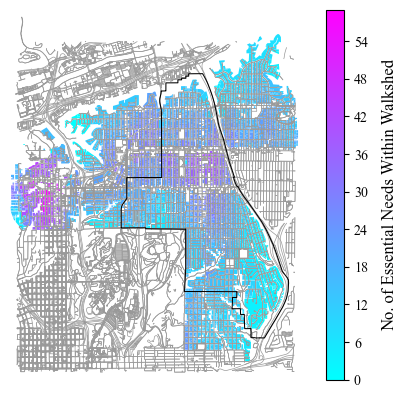

In [174]:
# Graph results for NP + neighbors
# Extract polygons with boundaries of North Park
northpark_gdf = gdf_sdpd[gdf_sdpd['name'].str.contains("NORTH PARK|BURLINGAME", na=False, case=False)]
np_bounds = gpd.GeoSeries(unary_union(northpark_gdf['geometry']))
np_bounds = np_bounds.set_crs('EPSG:2230')
# Perform merge of walkshed scores and NP + neighbor residences
np_n_residential_uses_merged = pd.merge(np_n_residential_uses, walkshed_gdf_npn.drop(['geometry'],axis=1), how='left', on='objectid')
# Get (slightly narrower) network graph around North Park + neighbors area for visualization purposes
G_NPN = ox.graph_from_bbox(32.775,32.715,-117.11,-117.17,retain_all=True)
# Plot heatmap for point totals
ax = np_n_residential_uses_merged.to_crs('EPSG:4326').plot(column = 'Total Access Score', cmap = 'cool', legend=True)
ox.plot_graph(G_NPN, ax=ax, node_size=0, edge_linewidth=0.5, bgcolor="none", show=False, close=False)
colorbar = ax.get_figure().get_axes()[1]
colorbar.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
colorbar.set_ylabel("No. of Essential Needs Within Walkshed", 
                    labelpad=10, fontsize=12, fontfamily='Times New Roman')
colorbar.yaxis.set_tick_params(labelsize=10, labelfontfamily='Times New Roman') 
np_bounds.to_crs(epsg=4326).plot(ax=ax, facecolor = 'none', edgecolor="black", linewidth=0.75)
plt.show()

In [2]:
walkshed_gdf_sd = gpd.read_file('SD_Walksheds.geojson')
sd_residential_uses = gpd.read_file('SD_Residential_Uses.geojson')

/var/folders/v8/9cfy1gdx1sld3kvlqhb266v80000gn/T/ipykernel_66049/722847165.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sd_residential_uses_merged_test = sd_residential_uses_merged[(sd_residential_uses_merged['geometry'].centroid.y>32.7) & (sd_residential_uses_merged['geometry'].centroid.y<33.05)]


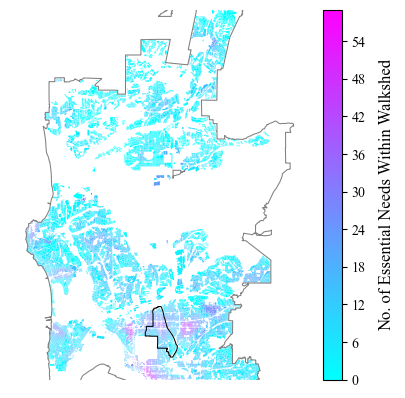

In [18]:
# Repeat for SD
sd_residential_uses_merged = pd.merge(sd_residential_uses, walkshed_gdf_sd.drop(['geometry'],axis=1), how='left', on='objectid')
# Get (slightly narrower) network graph around North Park + neighbors area for visualization purposes
# G_SD = ox.graph.graph_from_place("San Diego, California, USA", retain_all=True)
# Plot heatmap for point totals
sd_residential_uses_merged_test = sd_residential_uses_merged[(sd_residential_uses_merged['geometry'].centroid.y>32.7) & (sd_residential_uses_merged['geometry'].centroid.y<33.05)]
ax = sd_residential_uses_merged_test.to_crs('EPSG:4326').plot(column = 'Total Access Score', cmap = 'cool', legend=True)
# ox.plot_graph(G_SD, ax=ax, node_size=0, edge_linewidth=0.5, bgcolor="none", show=False, close=False)
colorbar = ax.get_figure().get_axes()[1]
colorbar.yaxis.set_major_locator(mticker.MaxNLocator(integer=True))
colorbar.set_ylabel("No. of Essential Needs Within Walkshed", 
                    labelpad=10, fontsize=12, fontfamily='Times New Roman')
colorbar.yaxis.set_tick_params(labelsize=10, labelfontfamily='Times New Roman') 
np_bounds.to_crs(epsg=4326).plot(ax=ax, facecolor = 'none', edgecolor="black", linewidth=0.75)
sd_bounds.to_crs(epsg=4326).plot(ax=ax, facecolor = 'none', edgecolor="gray", linewidth=0.75)
ax.set_xlim([-117.3, -116.975])
ax.set_ylim([32.7, 33.05])
plt.axis('off')
plt.show()